<p><img alt="Colaboratory logo" height="65px" src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" align="left" hspace="10px" width="20%" vspace="15px"></p>

<h1 align="center"> Prueba Técnica Profesional III Departamento de Datos no Estructurados  </h1>

<p style=»text-align: justify;»>
El Departamento de Analítica No estructurada busca profesionales con fuertes capacidades técnicas y sobretodo una fuerte capacidad analítica. Por consiguiente esta prueba intenta poner a prueba la forma en la que plantea y soluciona problemas. Es importante que presente el código que usa para resolver el problema con el único motivo de medir sus capacidades.

Se recomienda que sea ordenado en su código y siga los lineamientos establecidos, aún así la prueba tiene un grado de flexibilidad. Se evaluará el orden y la creatividad a la hora de presentar la información. 
</p>


**Nota** <br>
Tenga en cuneta que éste ejercicio es hipotético y el banco no usará su trabajo más que para evaluar sus habilidades para el cargo


#### **Objetivo**
El objetivo de esta prueba es lograr un filtro que discrimine automáticamente un tipo de documento sin información relevante: páginas en blanco. Se busca que este filtro reciba como entrada una carpeta con imágenes de documentos diversos y produzca como salida dos carpetas, una con imágenes de páginas en blanco y otra con imágenes de páginas con contenido.

Páginas con solo el membrete del documento se consideran páginas en blanco, así como las que, al momento de ser escaneadas, alcanzan a reflejar contenido ininteligible del reverso de la página.

## Clasificación de Imágenes

### 1.Importe las imágenes
En la carpeta adjunta se encontrará con documentos tanto en blanco como con contenido. Su objetivo es generar un modelo que clasifique los elementos en "Con Contenido" y "Sin Contenido". Para eso puede utilizar reglas o modelos específicos.

**_Solución:_**

Se cargaron las carpetas fuente suministradas por la entidad a un repositorio Github para el posterior desarrollo del ejercicio. 

La carga de la información a Colab se realizó con la siguiente instrucción:

In [ ]:
! git clone https://github.com/HenryRR/Prueba-tecnica.git

Cloning into 'Prueba-tecnica'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 274 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (274/274), 203.62 MiB | 36.97 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (517/517), done.


### 2. Estructure la información
Debido a que las imágenes son archivos separados lo primero que debe hacer es importarlas (recuerde que una imagen es esencialmente un arreglo de vectores), puede estructurarlas a su gusto y marcar de ser necesario aquellas que va usar como test de pruebas. 

**_Solución:_**

De las imágenes suministradas se procedió a realizar una agregación aleatoria para contar con los archivos de entrenamiento, prueba y validación, los cuales serán utilizados para el desarrollo del caso.

Las imágenes fueron clasificadas en las direcciones relacionadas a continuación:

In [ ]:
train_data_dir = "/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Train"
validation_data_dir = "/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Test"
valid_data_dir = "/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Validacion"

### 3. Describa su Estrategia de Análisis
<p>Tiene libertad en la metodología para la clasificación. Aun así debe describir brevemente como realizará el análisis. Por ejemplo, si usará un modelo en donde requiera clasificar una cantidad pequeña de la data menciónelo o si planea condicionar la clasifiaciones a reglas indique que reglas usará. Además si usa herramientas externas descríbalas y explique. </p>

**_Solución:_**

Para el desarrollo de este caso se pensó en una solución que presentara resultados óptimos y que no comprometiera demasiado tiempo en su ejecución. Es por esto que se realizó la parametrización de algunas características, para que fueran uniformes y cuya solución fuera expedita.

En este sentido, para realizar el pre procesamiento de la información se definió el ancho y la altura de las imágenes que serían objeto de procesamiento y sobre estas se decidió generar imágenes sintéticas que presentaran ligeras variaciones, como por ejemplo ampliación o disminución, rotación o desplazamientos; esto con el fin de lograr un entrenamiento eficaz y obtener mejores resultados en el modelo de clasificación.

Para definir el modelo de clasificación a utilizar, se establecieron los parámetros de entrenamiento y se hizo uso de un modelo pre entrenado denominado VGG16 el cual ha presentado resultados sobresalientes en ejercicios de clasificación de imágenes. Razón por la cual consideré interesante ver su aplicación en este desarrollo.

Luego de entrenar del modelo con las imágenes fuente suministradas, se realizó una prueba aleatoria para observar el comportamiento y posteriormente se estructuró el modelo para que realice la clasificación de las imágenes en las carpetas “Con contenido” y “Sin contenido” de forma automática.

A continuación se presenta el desarrollo:


In [ ]:
# Se cargan las librerías que se utilizarán en el desarrollo
from keras.models import Sequential, Model
from keras.models import load_model
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix


In [ ]:
# Parametrización
width_shape = 224   # Ancho de la imagen
height_shape = 224  # Altura de la imagen
num_classes = 2     # Clases (blanco, documentos)
epochs = 15         # Epocas para el entrenamiento de la red neuronal
batch_size = 32     # Cantidad de imágenes sintéticas             

In [ ]:
# Generación de imágenes sintéticas para optimizar el entrenamiento del modelo

# Parámetros para el grupo de imágenes de entrenamiento
train_datagen = ImageDataGenerator(  
    rotation_range=20,                          #Rotar la imágen
    zoom_range=0.2,                             #Zoom de la imágen
    width_shift_range=0.1,                      #Desplazamiento horizontal
    height_shift_range=0.1,                     #Desplazamiento vertical
    horizontal_flip=True,                       #Dar vuelta horizontalmente
    vertical_flip=False,                        #Dar vuelta verticalmente
    preprocessing_function=preprocess_input)    #Pre procesamiento de Keras

# Parámetros para el grupo de imágenes de prueba
valid_datagen = ImageDataGenerator(    
    rotation_range=20,                          #Rotar la imágen
    zoom_range=0.2,                             #Zoom de la imágen
    width_shift_range=0.1,                      #Desplazamiento horizontal
    height_shift_range=0.1,                     #Desplazamiento vertical
    horizontal_flip=True,                       #Dar vuelta horizontalmente
    vertical_flip=False,                        #Dar vuelta verticalmente
    preprocessing_function=preprocess_input)    #Preprocesamiento de Keras

# Generación sintética de imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(        #Aumentación de imágenes para entrenamiento (transformaciones) 
    train_data_dir,                                         #Dirección de imágenes
    target_size=(width_shape, height_shape),                #Dimensiones de imágenes
    batch_size=batch_size,                                  #Cantidad de imágenes sintéticas
    #save_to_dir='',                                        #No se guardan en el directorio
    class_mode='categorical')                               #Clase categórica por que hay 2 clases

# Generación sintética de imágenes de prueba
validation_generator = valid_datagen.flow_from_directory(   #Aumentación de imágenes para prueba (transformaciones)  
    validation_data_dir,                                    #Dirección de imágenes
    target_size=(width_shape, height_shape),                #Dimensiones de imágenes
    batch_size=batch_size,                                  #Cantidad de imágenes sintéticas
    #save_to_dir='',                                        #No se guardan en el directorio
    class_mode='categorical')                               #Clase categórica por que hay 2 clases

Found 218 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [ ]:
# Modelo de red neuronal VGG16

nb_train_samples = 218              #Muestras a entrenar
nb_validation_samples = 29          #Muestras a validar

image_input = Input(shape=(width_shape, height_shape, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')   #Se define el modelo pre entrenado VGG16 con sus parámetros

last_layer = model.get_layer('fc2').output                                      #Se selecciona la última capa del modelo
out = Dense(num_classes, activation='softmax', name='output')(last_layer)       #Se agrega capa densa que tiene como salida el número de clases
custom_vgg_model = Model(image_input, out)                                      #Se da nombre al modelo 

for layer in custom_vgg_model.layers[:-1]:                                      #Transferencia de aprendizaje (Solo se entrenará la última capa)
	layer.trainable = False                             
    

custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])   #Compila el modelo

custom_vgg_model.summary()                                                      #Estructura de la red

model_history = custom_vgg_model.fit_generator(                                 #Entrenar el modelo con las imágenes suministradas y con los parámetros definidos previamente
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    validation_steps=nb_validation_samples//batch_size)

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
6/6 [==============================] - 100s 16s/step - loss: 0.3419 - accuracy: 0.9140
Epoch 2/15
6/6 [==============================] - 97s 16s/step - loss: 0.3209 - accuracy: 0.9247
Epoch 3/15
6/6 [==============================] - 97s 16s/step - loss: 0.3409 - accuracy: 0.9032
Epoch 4/15
6/6 [==============================] - 99s 16s/step - loss: 0.3266 - accuracy: 0.9115
Epoch 5/15
6/6 [==============================] - 97s 16s/step - loss: 0.3402 - accuracy: 0.8925
Epoch 6/15
6/6 [==============================] - 97s 16s/step - loss: 0.3041 - accuracy: 0.9247
Epoch 7/15
6/6 [==============================] - 97s 16s/step - loss: 0.3059 - accuracy: 0.9086
Epoch 8/15
6/6 [==============================] - 97s 16s/step - loss: 0.3277 - accuracy: 0.9140
Epoch 9/15
6/6 [==============================] - 99s 16s/step - loss: 0.3456 - accuracy: 0.8854
Epoch 10/15
6/6 [==============================] - 97s 16s/step - loss: 0.3384 - accuracy: 0.9032
Epoch 11/15
6/6 [===========

In [ ]:
# Se guarda el modelo
custom_vgg_model.save("model_VGG16.h5")

Predicción de un caso particular usando el modelo VGG16

Documento


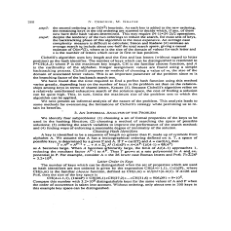

In [ ]:
# Predicción de la clasificación de una imágen

names = ['Blaco','Documento']                   #Nombres de las clases

modelt = load_model("model_VGG16.h5")           #Cargo el modelo

imaget_path = "/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Test/Documento/page-140.png"      #Ruta de la imágen de validación
imaget_path = cv2.imread(imaget_path)                                                               #Lee la imágen
imaget=cv2.resize(imaget_path, (width_shape, height_shape), interpolation = cv2.INTER_AREA)         #Ajusta las dimensiones de la imágen
xt = np.asarray(imaget)                                                                             
xt=preprocess_input(xt)                         #Pre procesamiento de imágenes    
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)                      #Predicción

print(names[np.argmax(preds)])                  #Imprime en pantalla la predicción
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()                                      #Muestra la imágen

In [ ]:
# Clasificación automática de imágenes en las carpetas "Doc_con_contenido" y "Doc_sin_contenido"

valid_data_dir = "/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Validacion"        #Dirección de la carpeta de validación
files_names = os.listdir(valid_data_dir)            #Lista de nombres de los archivos

if not os.path.exists('Doc_con_contenido'):         #Crea la carpeta Doc_con_contenido
    os.makedirs('Doc_con_contenido')

if not os.path.exists('Doc_sin_contenido'):         #Crea la carpeta Doc_sin_contenido
    os.makedirs('Doc_sin_contenido')

conteo1 = 0         #Conteo
conteo2 = 0         

for file_name in files_names:                       #Condicional para que recorra las imágenes
    #print(file_name)
    image_path = valid_data_dir + "/" + file_name
    image = cv2.imread(image_path)                  #Lee las imágenes

    imaget=cv2.resize(image, (width_shape, height_shape), interpolation = cv2.INTER_AREA) #Ajusta las imágenes
    xt = np.asarray(imaget)
    xt=preprocess_input(xt)                         #Pre procesamiento de imágenes
    xt = np.expand_dims(xt,axis=0)
    preds = modelt.predict(xt)                      #Predicción
    result_valid = names[np.argmax(preds)]          #Nombre de la predicción

    if result_valid == "Documento":                 #Condición para que guarde la imágen en la carpeta con contenido
        cv2.imwrite("/content/Doc_con_contenido" + "/image" + str(conteo1) + ".jpg" , image)
        conteo1 += 1
    else:                                           #Condición para que guarde la imágen en la carpeta sin contenido
        cv2.imwrite("/content/Doc_sin_contenido" + "/image" + str(conteo2) + ".jpg" , image)
        conteo2 += 1

### 4. Interpretación de Resultados
<p>Al final tiene que presentar la información en una matriz que muestre la calidad de su clasificación y evaluarla con la medida que guste. </p>
<br>
<img src="https://www.ecured.cu/images/3/31/Matrices_de_confusi%C3%B3n.png" >

**_Solución:_**



MATRIZ DE CONFUSIÓN

Found 29 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           0     0.7000    0.9333    0.8000        15
           1     0.8889    0.5714    0.6957        14

    accuracy                         0.7586        29
   macro avg     0.7944    0.7524    0.7478        29
weighted avg     0.7912    0.7586    0.7496        29



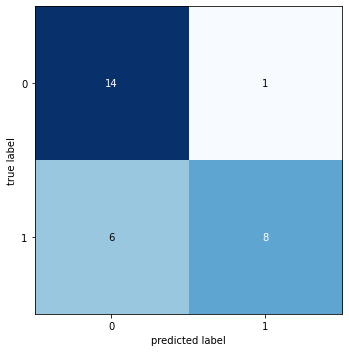

In [ ]:
# Matriz de confusión

names = ['Blaco','Documento']           #Nombre de las clases

test_data_dir = '/content/Prueba-tecnica/Ejercicio_1_Imagenes/Bases/Test'  # Dirección de la carpeta de prueba

test_datagen = ImageDataGenerator()         #Llama el generador de imágenes

test_generator = test_datagen.flow_from_directory(      #Aumentación de imágenes para validación (transformaciones)
    test_data_dir,                                      #Dirección de imágenes de prueba
    target_size=(width_shape, height_shape),            #Dimensiones de imágenes
    batch_size = batch_size,                            #Cantidad de imágenes transformadas
    class_mode='categorical',                           #Clase categórica por que hay 2 clases
    shuffle=False)                                      #Guarda el orden del data set

custom_Model= load_model("model_VGG16.h5")              #Carga el modelo

predictions = custom_Model.predict_generator(generator=test_generator)      #Predicción

y_pred = np.argmax(predictions, axis=1)                 #Valor máximo de la predicción
y_real = test_generator.classes                         #Valor real


matc=confusion_matrix(y_real, y_pred)                   #Constuye la matriz de confusión

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), show_normed=False)      #Gráfica
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4)) #Presenta las métricas

De las métricas presentadas se puede decir que el modelo no se encuentra sobre ajustado, además el modelo presenta una precisión del 76% en la clasificación de las imágenes, lo cual se podría considerar como una predicción aceptable, pero con oportunidad de mejora.

De la matriz de confusión se puede interpretar que el 93% es clasificado como verdaderos positivos, mientras que el 57% son verdaderos negativos; esto genera una distorsión en cuanto a los falsos positivos y sería una oportunidad de mejora considerando mayor cantidad de información para el entrenamiento del modelo.


## **Conclusiones:**


1.	El uso del modelo pre entrenado VGG16 presentó resultados aceptables.
2.	La precisión del modelo de clasificación es de 76%.
3.	El modelo no está sobre ajustado.
4.	El modelo se podría optimizar si se toma mayor información en el entrenamiento o se incrementa el número de épocas.
5.	Existen otros modelos pre entrenados como VGG19 o Mobilenet   los cuales en ejercicios posteriores sería interesante ponerlos en producción para evaluar sus resultados.
6.  Se podría construir un modelo de clasificación partiendo de cero, pero el entrenamiento podría tardar mucho tiempo dado que se debería contar con gran cantidad de información para lograr resultados óptimos. 
